# The material presented in this notebook is for using in Introduction to Deep Learning ECE.685D course, Duke University, Fall 2020.

## Regression and Classification
* ### Linear Regression in pytorch
* ### Closed form solution vs. Optimization
* ### Logistic Regression in pytorch

## __Importing modules and packages__

In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import time
import numpy as np
from sklearn import datasets

## Make synthetic data for Regression
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html

(100, 1) (100,) ()


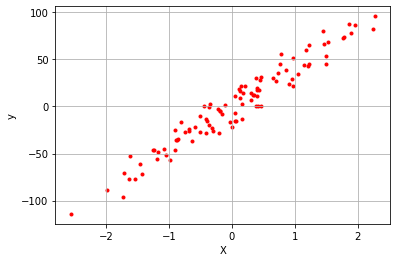

In [2]:
n_samples = 100
n_features = 1
n_informative = 1 # number of features used to generate y
noise = 10
def make_regression(n_samples, n_features, n_informative, noise):
    X, y, w = datasets.make_regression(n_samples=n_samples, n_features=n_features,
                                      n_informative=n_informative, noise=noise, bias = 0, coef=True, random_state=0)
    return X, y, w
X, y, w = make_regression(n_samples, n_features, n_informative, noise)
print(X.shape,y.shape,w.shape)
plt.scatter(X[:,0], y, color='r', marker='.')
plt.xlabel('X')
plt.ylabel('y')
plt.grid()
plt.show()

## Make synthetic data for Classification
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification

(1000, 2) (1000,)


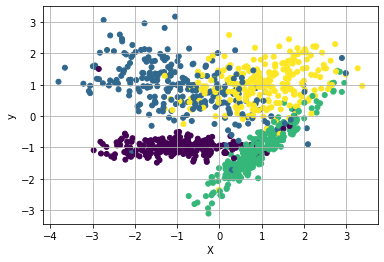

In [3]:
n_samples = 1000
n_features = 2
n_informative = 2 # number of features used to generate y
n_classes = 4
def make_classification(n_samples, n_features, n_informative, n_classes):
    X, y = datasets.make_classification(n_samples=n_samples, n_features=n_features,
                                      n_informative=n_informative, n_redundant=0, n_classes=n_classes, 
                                       n_clusters_per_class=1, random_state=0)
    return X, y
X, y = make_classification(n_samples, n_features, n_informative, n_classes)
print(X.shape,y.shape)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25)
plt.xlabel('X')
plt.ylabel('y')
plt.grid()
plt.show()

## [Linear Regression](https://en.wikipedia.org/wiki/Linear_regression)

In [4]:
n_samples = 100
n_features = 1
n_informative = n_features
noise = 10
X, y, w = make_regression(n_samples, n_features, n_informative, noise)
X, y ,w = torch.from_numpy(X).float(), torch.from_numpy(y).float(), torch.from_numpy(w).float()

### Closed form solution

Suppose that $X \in \mathbb{R}^{n \times m}$ with $X^TX$ invertible (nonsigular) and $Y \in \mathbb{R}^n$, and that $Y \sim N(Xw, \sigma^2 I)$.  
You learned in class that the maximum likelihood estimate $\hat{w}$ of ${w}$ is given by

$\hat{w} = (X^TX)^{-1}X^TY$


The loss function  
$L(w) = (Y-\hat{Y})^T(Y-\hat{Y}) = (Y-Xw)^T(Y-Xw) = Y^TY-Y^TXw-w^TX^TY+(Xw)^TXw$  
$= Y^TY-2w^TX^TY+w^TX^TXw$  
$\frac{\partial L(w)}{\partial w} = 0 - 2X^TY + 2X^TXw$  
Set $\frac{\partial L(w)}{\partial w} = 0$ we have  
$X^TXw = X^TY \Rightarrow \hat{w}=(X^TX)^{-1}X^TY$

True parameters: tensor(42.3855)
Estimated parameters: tensor([42.5717])
Mean Squared Error (MSE): 114.83204650878906


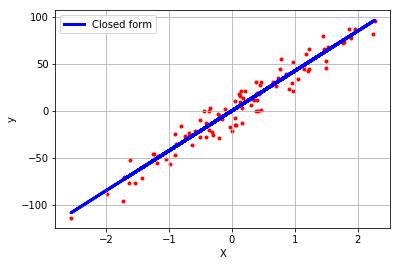

In [5]:
w_hat = X.t().matmul(X).inverse().matmul(X.t()).matmul(y)
y_hat = X.matmul(w_hat)
criterion = nn.MSELoss()
mse = criterion(y_hat,y) # (y_hat-y).pow(2).mean()
print('True parameters:', w)
print('Estimated parameters:', w_hat)
print('Mean Squared Error (MSE):', mse.item())
plt.scatter(X[:,0].numpy(), y.numpy(), color='r', marker='.')
plt.plot(X[:,0].numpy(), y_hat.numpy(), color='blue', linewidth=3, label='Closed form')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.grid()
plt.show()

### Optimization
We use [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) as an iterative method for solving general (nonlinear) optimization problems. Unlike [SGD](https://en.wikipedia.org/wiki/Stochastic_gradient_descent), L-BFGS requires to train with all data. L-BFGS is a quasi-Newton method which consumes much more memory and converges better than SGD and thus is suitable for small dataset.

True parameters:  tensor(42.3855)
Estimated parameters:  Parameter containing:
tensor([[42.5717]], requires_grad=True)
Mean Squared Error (MSE):  114.83204650878906


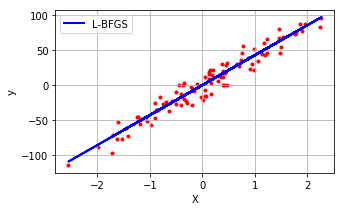

In [6]:
num_iter = 5   ## Number of iterations
Objected_Oriented = True

#======================================= With Objected oriented way ================================================
if Objected_Oriented:
    class linear_regression(nn.Module):
        def __init__(self, n_features, out_features, bias):
            super(linear_regression, self).__init__()
            self.linear = nn.Linear(in_features=n_features, out_features=1, bias=bias)

        def forward(self, x):
            return self.linear(x)

    model = linear_regression(n_features, 1, False)
    criterion = nn.MSELoss()
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.8)
    losses = []
    for i in range(num_iter):
        def closure():
            optimizer.zero_grad()
            y_hat = model(X)     # Forward Pass
            loss = criterion(y_hat.squeeze(), y)
            loss.backward()      # backward Pass
            losses.append(loss.item())
            return loss
        optimizer.step(closure)

    with torch.no_grad():
        model.eval()
        y_hat = model(X)
        mse = criterion(y_hat.squeeze(), y)
    Weight = model.linear.weight

#======================================= Witout Objected oriented way ================================================
else:
    model = nn.Linear(in_features=n_features, out_features=1, bias=False) # y = Xw
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.8)
    criterion = nn.MSELoss()
    # Train
    model.train('True')
    losses = []
    for i in range(num_iter):
        def closure():
            y_hat = model(X) # Forward Pass
            loss = criterion(y_hat.squeeze(), y)
            optimizer.zero_grad()
            loss.backward() # Backward Pass
            losses.append(loss.item())
            return loss
        optimizer.step(closure)
    # Evaluate
    with torch.no_grad():
        model.train('False')
        y_hat = model(X)
        mse = criterion(y_hat.squeeze(),y)
    Weight = model.weight
#======================================= Showing the results ===========================================================
    
print('True parameters: ', w)
print('Estimated parameters: ', Weight)
print('Mean Squared Error (MSE): ', mse.item())
plt.figure(figsize=(5,3))
plt.scatter(X[:,0].numpy(), y.numpy(), color='r', marker='.')
plt.plot(X[:,0].numpy(), y_hat.numpy(), color='blue', linewidth=2, label='L-BFGS')
plt.legend()
plt.xlabel('X')
plt.ylabel('y')
plt.grid()
plt.show()

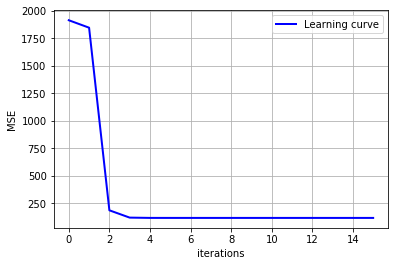

In [7]:
plt.figure()
plt.plot(list(range(len(losses))), losses, color='blue', linewidth=2, label='Learning curve')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('MSE')
plt.grid()
plt.show()

### Closed form solution vs. Optimization
You may ask why we need optimization method as we can always derive the closed form solutions.  
The [complexity](https://en.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations) (in general case and without any structure on $X$) of inverting a matrix $X \in R^{n \times n}$ is $O(n^3)$. Imagine we have a model with a large number of parameters, inverting a matrix actually is much more computationally expensive than gradually optimizing your model.

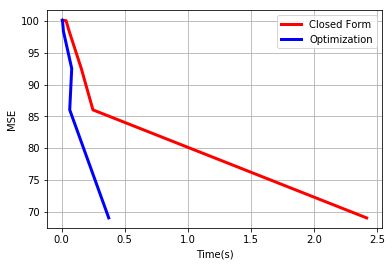

In [8]:
n_samples = 10000
n_features = [1,10,100,500,1000,3000]
n_informative = n_features
noise = 10
criterion = nn.MSELoss()
closed_form_time = []
closed_form_mse = []
optimization_time = []
optimization_mse = []
for i in range(len(n_features)):
    X, y, w = make_regression(n_samples, n_features[i], n_informative[i], noise)
    X, y ,w = torch.from_numpy(X).float(), torch.from_numpy(y).float(), torch.from_numpy(w).float()
    s = time.time()
    
    #Closed form
    w_hat = X.t().matmul(X).inverse().matmul(X.t()).matmul(y)    
    y_hat = X.matmul(w_hat)
    closed_form_time.append(time.time()-s)
    closed_form_mse.append(criterion(y_hat,y))
    
    #optimization
    s = time.time()
    num_iter = 1
    model = nn.Linear(in_features=n_features[i], out_features=1, bias=False) # y = Xw
    optimizer = torch.optim.LBFGS(model.parameters(), lr=0.8)
    # Train
    model.train('True')
    losses = []
    for i in range(num_iter):
        def closure():
            y_hat = model(X) # Forward Pass
            loss = criterion(y_hat.squeeze(), y)
            optimizer.zero_grad()
            loss.backward() # Backward Pass
            losses.append(loss.item())
            return loss
        optimizer.step(closure)
    with torch.no_grad():
        model.train('False')
        y_hat = model(X)
        optimization_time.append(time.time()-s)
        optimization_mse.append(criterion(y_hat.squeeze(),y))
plt.figure()
plt.plot(closed_form_time, closed_form_mse, color='red', linewidth=3, label='Closed Form')
plt.plot(optimization_time, optimization_mse, color='blue', linewidth=3, label='Optimization')
plt.legend()
plt.xlabel('Time(s)')
plt.ylabel('MSE')
plt.grid()
plt.show()

## [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression)

In [5]:
n_samples = 10
n_features = 2
n_informative = n_features
n_classes = 4
X, y = make_classification(n_samples, n_features, n_informative, n_classes)
print(y)
X, y = torch.from_numpy(X).float(), torch.from_numpy(y).long()

[0 0 1 0 3 1 2 3 2 1]


$Y = Softmax(Xw) = \frac{exp(Xw_i)}{\sum_{j}exp(Xw_j)}$

Logistic Regression generally does not have a closed form solution. We use SGD to fit the model iteratively. Here we use all data to train the model since we do not have the problem of memory limitation, and thus not stochastic.

In [10]:
num_iter = 30
model = nn.Linear(in_features=n_features, out_features=n_classes, bias=False) # y = Xw
optimizer = torch.optim.SGD(model.parameters(), lr=1) # Experiment to see the senstivity of learning rate with SGD
criterion = nn.CrossEntropyLoss()
# Train
model.train('True')
losses = []
for i in range(num_iter):
    y_hat = model(X) # Forward Pass
    loss = criterion(y_hat, y) # -log(softmax(y_hat)) == nn.NLLLoss(nn.LogSoftmax(y_hat))
    optimizer.zero_grad()
    loss.backward() # Backward Pass
    losses.append(loss.item())
    optimizer.step()
# Evaluate
with torch.no_grad():
    model.train('False')
    y_hat = model(X)
    nll = criterion(y_hat.squeeze(),y)
print('Estimated parameters: ', model.weight)
print('Negative Log Likelihood (NLL): ', nll.item())

Estimated parameters:  Parameter containing:
tensor([[-1.0774, -1.4855],
        [-0.8403,  1.2251],
        [ 1.2671, -1.6921],
        [ 0.8143,  1.2214]], requires_grad=True)
Negative Log Likelihood (NLL):  0.5309156179428101


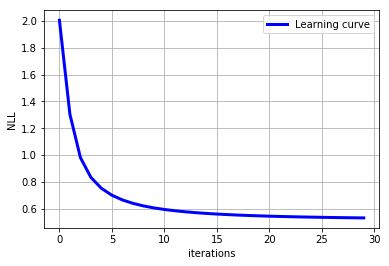

In [11]:
plt.figure()
plt.plot(list(range(len(losses))), losses, color='blue', linewidth=3, label='Learning curve')
plt.legend()
plt.xlabel('iterations')
plt.ylabel('NLL')
plt.grid()
plt.show()

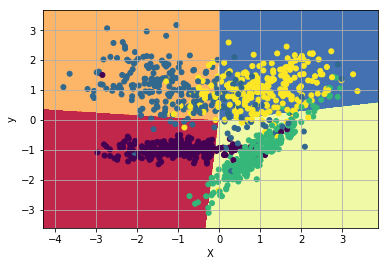

In [12]:
def plot_decision_boundary(model, X):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = torch.meshgrid(torch.arange(x_min, x_max, h), torch.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    X = torch.cat([xx.reshape(-1,1), yy.reshape(-1,1)],dim=1)
    y_hat = model(X)
    Z = y_hat.topk(1,1,True,True)[1]
    Z = Z.view(xx.size())
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    return
    
    
plt.figure()
plot_decision_boundary(model, X)
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y, s=25)
plt.xlabel('X')
plt.ylabel('y')
plt.grid()
plt.show()